In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from scipy import stats

## Notebook description
This notebook pre-processes LC-MS data for plotting. The data comes as atomwise fraction 13C, but we want it as fraction 12C since 12C comes from the inorganic pool. We then infer the fraction of intracellular inorganic carbon that is 12C by comparing labeling of arginine and glutamate (as described in the Methods). Using assumptions detailed in the Methods, we can then infer the fraction of 3PG production flux due to rubisco in each sample from the labeling patterns of serine in the experiment and controls. 

In [2]:
# Load amino acid LCMS data
float_types = ['ser', 'his', 'val', 'thr', 'pro', 'arg', 'glu']
short_names = float_types
long_names = ['Serine', 'Histidine', 'Valine', 'Threonine', 'Proline', 'Arginine', 'Glutamate']
dtypes = dict((aa, pd.np.float64) for aa in float_types)
fname = 'data/LCMS/062220_repeat2_f13c_extracted_transpose.csv'

# Data is the fraction of C atoms that are 13C
frac13c_df = pd.read_csv(fname, index_col=0, na_values='NAN', dtype=dtypes)

# Convert data to fraction 12C from fraction 13C
frac12c_df = frac13c_df.copy()
frac12c_df[float_types] = 1.0 - frac13c_df[float_types]

# Serine and valine are products of lower glycolysis, so they are good
# proxies for 3PG labeling in the control. His is produced from ribose
# with the addition of a single C1 unit (1/6) carbons from THF.
# The remaining measured AAs are in some way connected to the TCA cycle and
# anaplerotic inorganic carbon incorporation, so they are bad proxies for the input carbon. 
representative_aas = ['ser', 'val', 'his']

for aa in representative_aas:
    for sn in ['CAfree_bioreactor', 'CCMB1_bioreactor']:
        mask = frac12c_df.sample_name == sn
        vals = frac12c_df[mask][aa].values
        
        # Drop zeros
        pct_vals = vals[vals>0]*100
        mean_std_12c = np.mean(pct_vals), np.std(pct_vals)
        print(sn, aa, 'mean 12C labeling: %.2f%% +/- %.1f%%' % mean_std_12c)
    print()

# Take a look at the underlying data to make sure.
frac12c_df.to_csv('data/LCMS/062220_f12c_inferred.csv')
mask = frac12c_df.sample_name.isin(['CAfree_bioreactor', 'CCMB1_bioreactor'])
frac13c_df

CAfree_bioreactor ser mean 12C labeling: 0.67% +/- 0.0%
CCMB1_bioreactor ser mean 12C labeling: 2.16% +/- 0.6%

CAfree_bioreactor val mean 12C labeling: 0.74% +/- 0.0%
CCMB1_bioreactor val mean 12C labeling: 3.36% +/- 2.7%

CAfree_bioreactor his mean 12C labeling: 0.67% +/- 0.2%
CCMB1_bioreactor his mean 12C labeling: 3.61% +/- 1.6%



/Library/Python/3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead


,ser,his,val,thr,pro,arg,glu,sample_name,description
sample,,,,,,,,,
AF 1,0.993012,0.996269,0.992377,0.959409,0.948631,0.929029,0.960876,CAfree_bioreactor,"Control ambient air, bioreactor - CAfree:pFE-s..."
AF 2,0.993279,0.993070,0.992382,0.960480,0.947130,0.927408,0.954005,CAfree_bioreactor,"Control ambient air, bioreactor - CAfree:pFE-s..."
AF 3,0.993434,0.990183,0.993438,0.959988,0.953622,0.925855,0.949893,CAfree_bioreactor,"Control ambient air, bioreactor - CAfree:pFE-s..."
AF 4,0.993479,0.993791,0.992332,0.938930,0.942675,0.926680,0.959270,CAfree_bioreactor,"Control ambient air, bioreactor - CAfree:pFE-s..."
AF 5,0.983807,0.971023,0.983629,0.957774,0.958482,0.891947,0.970512,CCMB1_bioreactor,Experiment ambient air bioreactor - CCMB1:pCB'...
AF 6,0.971412,0.941823,0.972140,0.924698,0.931796,0.824865,0.950898,CCMB1_bioreactor,Experiment ambient air bioreactor - CCMB1:pCB'...
AF 7,0.972681,0.957104,0.921617,0.889837,0.921748,0.809620,0.942496,CCMB1_bioreactor,Experiment ambient air bioreactor - CCMB1:pCB'...
AF 8,0.985718,0.985713,0.988252,0.959540,0.971684,0.911513,0.976156,CCMB1_bioreactor,Experiment ambient air bioreactor - CCMB1:pCB'...
100% 13C biomass,0.989901,0.972911,0.991141,0.980710,0.980234,0.963422,0.971596,100% 13C biomass,100% 13C biomass


In [3]:
# Calculate the intracellular 13C and 12C fractions by comparing arginine with glutamate and proline.
# Gleizer et al. Cell 2019 average inferences from glu and pro comparisons (to arg). However the
# proline comparison gives a negative value for sample 7 so it has to be left out here. 
f13c_cyto_glu = 6 * frac13c_df.arg - 5 * frac13c_df.glu
f13c_cyto_pro = 6 * frac13c_df.arg - 5 * frac13c_df.pro

# Summary dataframe for saving and checking the calculation
df_data = {'sample_name': frac13c_df.sample_name, 'f13c_cyto_glu': f13c_cyto_glu, 'f13c_cyto_pro': f13c_cyto_pro}
cyto_ci_isotopes_df = pd.DataFrame(df_data)

# Notice below the negative f13C estimate from the proline/arginine comparison for samples 7, 9, 10, 11, 12
# In general the proline estimates are 1) lower for f13C 2) somewhat more suspect than glutamate/arginine as
# proline is derived from glutamate by 4 metabolic steps and iii) proline is substantially less abundant than
# glutamate and the raw counts are ≈2-5x lower for several samples. For this reason we used the arg/glu 
# comparison alone to estimate intracellular inorganic carbon levels. 
cyto_ci_isotopes_df['f13c_cyto'] = cyto_ci_isotopes_df['f13c_cyto_glu']

# Estimate shouldn't be lower than 0% or higher than 100%
cyto_ci_isotopes_df['f12c_cyto_inferred'] = np.clip(1.0 - cyto_ci_isotopes_df.f13c_cyto, 0, 1.0)
cyto_ci_isotopes_df['pct12c_cyto_inferred'] = 100*cyto_ci_isotopes_df.f12c_cyto_inferred

# Save and peek at the results
cyto_ci_isotopes_df.to_csv('data/LCMS/062220_f12co2_inferred.csv')
cyto_ci_isotopes_df

,sample_name,f13c_cyto_glu,f13c_cyto_pro,f13c_cyto,f12c_cyto_inferred,pct12c_cyto_inferred
sample,,,,,,
AF 1,CAfree_bioreactor,0.769793,0.831018,0.769793,0.230207,23.020680
AF 2,CAfree_bioreactor,0.794423,0.828794,0.794423,0.205577,20.557653
AF 3,CAfree_bioreactor,0.805670,0.787021,0.805670,0.194330,19.433006
AF 4,CAfree_bioreactor,0.763731,0.846705,0.763731,0.236269,23.626907
AF 5,CCMB1_bioreactor,0.499122,0.559272,0.499122,0.500878,50.087825
AF 6,CCMB1_bioreactor,0.194698,0.290211,0.194698,0.805302,80.530231
AF 7,CCMB1_bioreactor,0.145237,0.248975,0.145237,0.854763,85.476332
AF 8,CCMB1_bioreactor,0.588297,0.610655,0.588297,0.411703,41.170284
100% 13C biomass,100% 13C biomass,0.922556,0.879366,0.922556,0.077444,7.744366


In [4]:
# Print out some summary stats for our inferrences above.
# Calculate the mean f12c for the controls for reporting in the text
mean_isotope_df = cyto_ci_isotopes_df.groupby('sample_name').mean()
std_isotope_df = cyto_ci_isotopes_df.groupby('sample_name').std()

# Control is CAfree strain complemented by human CAII (Methods).
mean_control_f12c_cyto = mean_isotope_df.loc['CAfree_bioreactor'].f12c_cyto_inferred
std_control_f12c_cyto = std_isotope_df.loc['CAfree_bioreactor'].f12c_cyto_inferred

mean_exp_f12c_cyto = mean_isotope_df.loc['CCMB1_bioreactor'].f12c_cyto_inferred
std_exp_f12c_cyto = std_isotope_df.loc['CCMB1_bioreactor'].f12c_cyto_inferred

print('Average control has %.1f%% +/- %.1f%% 12C in the cytosol' % (
    100*mean_control_f12c_cyto, 100*std_control_f12c_cyto))
print('Average experiment has %.1f%% +/- %.1f%% 12C in the cytosol' % (
    100*mean_exp_f12c_cyto, 100*std_exp_f12c_cyto))

# Now we ask: what fraction of that 12C makes it onto serine in the control. 
mean_AA_labeling_df = frac12c_df.groupby('sample_name').mean()
mean_control_f12c_ser = mean_AA_labeling_df.loc['CAfree_bioreactor'].ser
baseline_12c_cycling_ser = mean_control_f12c_cyto / mean_control_f12c_ser
print('Control has an average of %.1f%% 12C on serine' % (100*mean_control_f12c_ser))
print('This is 1/%.1f of the cytosolic 12C pool' % (baseline_12c_cycling_ser))

Average control has 21.7% +/- 2.0% 12C in the cytosol
Average experiment has 64.3% +/- 22.0% 12C in the cytosol
Control has an average of 0.7% 12C on serine
This is 1/32.3 of the cytosolic 12C pool


In [5]:
# Now we infer the fraction of 3PG production flux that is due to rubisco.
# Assumptions:
# 1. DHAP has ≈0.6% 12C labeling in both exp and control.
#    a. Same becuse it is a direct product of glycerol -> DHAP -> 3PG -> serine.
#    b. 0.6% estimated from the labeling of serine and valine in the control.
# 2. RuBP has ≈0.6% 12C labeling in the experiment
#       estimated from serine, valine and histidine in the control.
# 3. Rubisco carboxylates from a pool with the 12C composition calculated from arg/glu comparison above. 
#       This fraction is inferred on a per-sample basis. 
f12c_dhap_assumed = mean_control_f12c_ser   # exp and control, assumed 0.6% see above
f12c_rubp_assumed = f12c_dhap_assumed       # only exp makes rubp
rel_rub_flux = frac12c_df.ser - f12c_dhap_assumed
rel_rub_flux /= (((f12c_dhap_assumed * 5 + cyto_ci_isotopes_df.f12c_cyto_inferred)/6)
                 - f12c_dhap_assumed)
mean_rub_3pg_production = rel_rub_flux[frac12c_df.sample_name == 'CCMB1_bioreactor'].mean()
print()
print('Mean inferred 3pg production flux fraction due to rubisco: %.1f%%' % (
    mean_rub_3pg_production*100))

# Make a dataframe with all the relevant data for plotting. 
df_data = dict(sample_name=frac12c_df.sample_name,
               ser_f12c=frac12c_df.ser,
               val_f12c=frac12c_df.val,
               his_f12c=frac12c_df.his,
               rel_rubisco_3PG_flux=rel_rub_flux,
               f12co2_inferred=cyto_ci_isotopes_df.f12c_cyto_inferred,
               description=frac12c_df.description)
summary_df = pd.DataFrame(df_data)

# The "relative rubisco flux" is meaningless for samples not expressing rubisco.
# Set those all to NAN

mask = np.logical_not(summary_df.sample_name.str.startswith('CCMB1'))
summary_df.loc[mask, 'rel_rubisco_3PG_flux'] = np.NaN
summary_df.to_csv('data/LCMS/062220_flux_inferrence.csv')
summary_df


Mean inferred 3pg production flux fraction due to rubisco: 13.4%


,sample_name,ser_f12c,val_f12c,his_f12c,rel_rubisco_3PG_flux,f12co2_inferred,description
sample,,,,,,,
AF 1,CAfree_bioreactor,0.006988,0.007623,0.003731,NaN,0.230207,"Control ambient air, bioreactor - CAfree:pFE-s..."
AF 2,CAfree_bioreactor,0.006721,0.007618,0.006930,NaN,0.205577,"Control ambient air, bioreactor - CAfree:pFE-s..."
AF 3,CAfree_bioreactor,0.006566,0.006562,0.009817,NaN,0.194330,"Control ambient air, bioreactor - CAfree:pFE-s..."
AF 4,CAfree_bioreactor,0.006521,0.007668,0.006209,NaN,0.236269,"Control ambient air, bioreactor - CAfree:pFE-s..."
AF 5,CCMB1_bioreactor,0.016193,0.016371,0.028977,0.115270,0.500878,Experiment ambient air bioreactor - CCMB1:pCB'...
AF 6,CCMB1_bioreactor,0.028588,0.027860,0.058177,0.164450,0.805302,Experiment ambient air bioreactor - CCMB1:pCB'...
AF 7,CCMB1_bioreactor,0.027319,0.078383,0.042896,0.145884,0.854763,Experiment ambient air bioreactor - CCMB1:pCB'...
AF 8,CCMB1_bioreactor,0.014282,0.011748,0.014287,0.112341,0.411703,Experiment ambient air bioreactor - CCMB1:pCB'...
100% 13C biomass,100% 13C biomass,0.010099,0.008859,0.027089,NaN,0.077444,100% 13C biomass


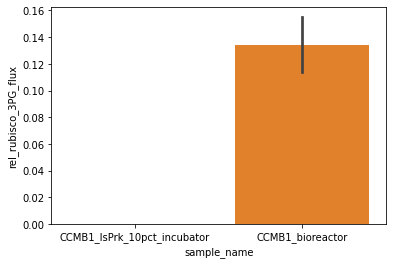

In [6]:
# Take a quick look at the inferrence for the rubisco-expressing samples.
# Note that the 10% CO2 control likely needs a separate calculation relative to the control grown in the same conditions.
sns.barplot(data=summary_df, x='sample_name', y='rel_rubisco_3PG_flux', order=['CCMB1_lsPrk_10pct_incubator', 'CCMB1_bioreactor'])

In [7]:
# Sampling for calculating 99% confidence interval on the 3PG flux due to rubisco.
control_f12ser = frac12c_df[frac12c_df.sample_name == 'CAfree_bioreactor'].ser.values
exp_f12ser = frac12c_df[frac12c_df.sample_name == 'CCMB1_bioreactor'].ser.values
f12co2_exp = cyto_ci_isotopes_df[cyto_ci_isotopes_df.sample_name == 'CCMB1_bioreactor'].f12c_cyto_inferred.values
shape = (int(1e5), 4)

# Assume f12 for DHAP follows distribution observed for serine in the control
f12c_dhap_samples = np.random.normal(loc=0.0062, scale=0.002, size=shape)

# RuBP and DHAP were assumed to have the same f12C. 
# Pessimistically assume that they are independent but have the same mean/stddev
# This will create more variation than setting them to the same values
f12c_rubp_exp_samples = np.random.normal(loc=0.0062, scale=0.001, size=shape)

# Using estimated f12co2 and f12ser distributions from the same experimental sample, as our
# model and basic intuition says they must be correlated (rubisco fixes CO2 into serine). 
# f12ser is a direct LC-MS measurement: assume 0.1% error 
f12c_ser_exp_samples = np.random.normal(loc=exp_f12ser, scale=0.001, size=shape)

# f12co2 is indirectly inferred from glutamate and arginine, assume larger 1% error.
f12co2_exp_samples = np.random.normal(loc=f12co2_exp, scale=0.05, size=shape)

rel_rub_flux_samples = f12c_ser_exp_samples -  f12c_dhap_samples
rel_rub_flux_samples /= (((f12c_dhap_samples*5 + f12co2_exp_samples)/6) - f12c_dhap_samples)
pct_rub_flux_samples = rel_rub_flux_samples*100

Inference of plausible range for rubisco fraction of 3PG production flux
Overall median: 14.4%
	 99% CI: 4.9-21.8%

Per-sample inference of rubisco flux range
Sample 0 median: 12.1%
	 99% CI: 5.1-20.8%
Sample 1 median: 16.8%
	 99% CI: 12.1-22.3%
Sample 2 median: 14.9%
	 99% CI: 10.6-19.9%
Sample 3 median: 11.9%
	 99% CI: 3.5-23.0%


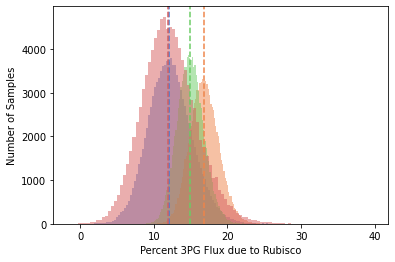

In [8]:
# Plot sampled distributions of rubisco flux for all four experimental samples.
plt.figure()
print('Inference of plausible range for rubisco fraction of 3PG production flux')
low, med, high = np.percentile(pct_rub_flux_samples.flatten(), [0.5, 50, 99.5])
print('Overall median: %.1f%%' % med)
print('\t 99%% CI: %.1f-%.1f%%' % (low, high))
print()
print('Per-sample inference of rubisco flux range')
pal = sns.color_palette('muted')
for c in range(4):
    plt.hist(pct_rub_flux_samples[:, c], bins=100, alpha=0.5, color=pal[c])
    low, med, high = np.percentile(pct_rub_flux_samples[:, c], [0.5, 50, 99.5])
    plt.axvline(med, ls='--', color=pal[c])
    print('Sample %d median: %.1f%%' % (c, med))
    print('\t 99%% CI: %.1f-%.1f%%' % (low, high))
    
plt.xlabel('Percent 3PG Flux due to Rubisco')
plt.ylabel('Number of Samples')
plt.show()